In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
import warnings
warnings.filterwarnings('ignore')

In [37]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [38]:
class GetMiniBatch:
    """
    Iterator to get a mini-batch

    Parameters
    ----------
    X : The following form ndarray, shape (n_samples, n_features)
      Training data
    y : The following form ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]


# Deep Neural Network Scratch

# Problem 1 
## Classification of fully connected layers

In [39]:
class FC:
    """
   Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer : Instance of initialization method
    optimizer : Instance of optimization method
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        ## Node optimization / initialization instance
        self.optimizer = optimizer
        self.initializer = initializer

        ## Initialize weights and biases in nodes
        self.W = self.initializer.W(n_nodes1, n_nodes2)
        self.B = self.initializer.B(n_nodes2, )
        
    def forward(self, X):
        self.X_prev = X
        A = X @ self.W + self.B
        return A

    def backward(self, dA):
        ## Gradient calculation
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X_prev.T @ dA
        
       ## Update weight / bias
        self.optimizer.update(self)
        dZ = dA @ self.W.T
        
        return dZ

# Problem 2
## Classification of initialization method

In [40]:
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2, )
        return B

# Problem 3
## Classification of optimization methods

In [41]:
class SGD:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.B -= self.lr * layer.dB
        layer.W -= self.lr * layer.dW

# Problem 4
## Classification of activation function

In [42]:
class Sigmoid:
    """
    Sigmoid function class
    """  
    def __init__(self):
        pass
    
    def forward(self, X):
        self.A = X
        return 1 / (1 + np.exp(-X))
    
    def backward(self, X):
        return X * (1- self.forward(self.A)) * self.forward(self.A)

In [43]:
class Tanh:
    """
    Tanh function class
    """
    def __init__(self):
        pass
    
    def forward(self, X):
        self.A = X
        return np.tanh(X)
    
    def backward(self, X):
        return X * (1 - self.forward(self.A)**2)

In [44]:
class Softmax:
    def __init__(self):
        pass
    
    def forward(self, X):
        X = X - np.max(X)
        return np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)
    
    def backward(self, X, y):
        batch_size = len(X)
        delta = 1e-7
        
        self.loss = -np.sum(y * np.log(X+delta)) / batch_size
        return X - y

# Problem 5 
## Creating a ReLU class

In [45]:
class ReLU:
    """
    ReLU function class
    """
    def forward(self, X):
        self.A = X
        return np.maximum(0, X)
    
    def backward(self, X):
        return X * (self.A > 0)

# Problem 6
## Initial value of weight

In [46]:
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        sigma = 1 / np.sqrt(n_nodes1)
        W = sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2, )
        return B

In [47]:
class HeInitializer:
    def W(self, n_nodes1, n_nodes2):
        sigma = np.sqrt(2 / n_nodes1)
        W = sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2, )
        return B

# Problem 7 
## Optimization Method

In [48]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.HB = None
        self.HW = None
        
    def update(self, layer):
        delta = 1e-7
        
        if self.HB is None:
            self.HB = np.zeros_like(layer.B)
            
        if self.HW is None:
            self.HW = np.zeros_like(layer.W)
        
        self.HB += layer.dB ** 2
        self.HW += layer.dW ** 2
        
        layer.B -= self.lr * layer.dB / (np.sqrt(self.HB)+delta)
        layer.W -= self.lr * layer.dW / (np.sqrt(self.HW)+delta)

# Problem 8
## Completion of class

In [49]:
from sklearn.preprocessing import OneHotEncoder
class ScratchDeepNeuralNetrowkClassifier():
    def __init__(self, hidden, lr=0.01, sigma=0.01, activation="sigmoid", optimizer="adagrad", verbose = True):
        self.hidden = hidden
        self.lr = lr
        self.sigma = sigma
        self.verbose = verbose
        self.FC = []
        self.activation = []

        ## Set initialization class by activation function
        if activation == "sigmoid":
            self.initializer = XavierInitializer()
            self.activefunc = Sigmoid
        elif activation == "tanh":
            self.initializer = XavierInitializer()
            self.activefunc = Tanh
        elif activation == "ReLU":
            self.initializer = HeInitializer()
            self.activefunc = ReLU
        else:
            self.initializer = SimpleInitializer(self.sigma)
        
        ## Optimization method
        if optimizer == "adagrad":
            self.optimizer = AdaGrad
        elif optimizer == "sgd":
            self.optimizer = SGD
        else:
            raise ValueError("No such a optimizer !!")
        
        ## Loss function record list
        self.train_loss = []
        self.val_loss = []
        
    def fit(self, X, y, X_val=None, y_val=None, epoch=5, batch_size=20):
        
        ## Whether to record the loss function of verification data
        calc_val = (X_val is not None) & (y_val is not None)
        
        ## One_hot conversion of objective variable
        y = self._one_hot_encoding(y) 
        if calc_val:
            y_val = self._one_hot_encoding(y_val) 
        
        ## Mini batch object definition
        get_mini_batch = GetMiniBatch(X, y, batch_size=batch_size)
        
        ## Set the number of nodes in the input layer and output layer
        self.n_features = X.shape[1] 
        self.n_output = y.shape[1]
        
        # == Create a fully connected layer＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
        #Create input layer
        self.FC.append(FC(self.n_features, self.hidden[0], self.initializer, self.optimizer(self.lr)))
        self.activation.append(self.activefunc())
        ## Create a hidden layer
        for i in range(len(self.hidden)-1):
            new_FC = FC(self.hidden[i], self.hidden[i+1], self.initializer, self.optimizer(self.lr))
            self.FC.append(new_FC)
            
            new_activefunc = self.activefunc()
            self.activation.append(new_activefunc)
       ## Create output layer
        self.FC.append(FC(self.hidden[-1], self.n_output, self.initializer, self.optimizer(self.lr)))
        self.activation.append(Softmax())    
        #＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
        
       ## Learning
        for ep in range(epoch):
            for mini_X, mini_y in get_mini_batch:
                self.level = 0
                ## Forward propagation＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
                Z_output = self._forward_propagation(mini_X)
                #＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
                
               ## Cross entropy calculation＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
                dA_output = self.activation[self.level].backward(Z_output, mini_y)
                dZ_output = self.FC[self.level].backward(dA_output)
                self.level -= 1
                #＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
                
               ## Backpropagation＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
                dZ0 = self._back_propagation(dZ_output)
                #＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
                
            ## Record of loss
            tr_loss = self._cross_entropy(self.predict_prob(X), y)
            self.train_loss.append(tr_loss)
            
            if self.verbose:
                    print("Train loss of epoch {}: {}".format(ep, tr_loss))
            
            if calc_val:
                va_loss = self._cross_entropy(self.predict_prob(X_val), y_val)
                self.val_loss.append(va_loss)
                
                
    def predict_prob(self, X):
        self.level=0
        return self._forward_propagation(X)
                
    def predict(self, X):
        y = np.argmax(self.predict_prob(X), axis=1)
        return y
    
    def _one_hot_encoding(self, y):
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_one_hot = enc.fit_transform(y[:, np.newaxis])
        return y_one_hot

    def _cross_entropy(self, X, y):
        batch_size = len(X)
        delta = 1e-7
        return -np.sum(y * np.log(X+delta)) / batch_size
    
    def _forward_propagation(self, X):
        max_level = len(self.hidden)
        
        A = self.FC[self.level].forward(X)
        Z = self.activation[self.level].forward(A)
        
        if self.level == max_level:
            return Z
        else:
            self.level += 1
            return self._forward_propagation(Z)
    
    def _back_propagation(self, X):
        min_level = 0

        dA = self.activation[self.level].backward(X)
        dZ = self.FC[self.level].backward(dA)

        if self.level == min_level:
            return dZ
        else:
            self.level -= 1
            return self._back_propagation(dZ)

# Problem 9
## Learning and estimation

In [50]:
dnn = ScratchDeepNeuralNetrowkClassifier([400, 200], lr=1e-3, activation="sigmoid", optimizer="adagrad")
dnn.fit(X_train, y_train, X_val, y_val, epoch=10, batch_size=20)

Train loss of epoch 0: 0.9622807440303401
Train loss of epoch 1: 0.7166325616482246
Train loss of epoch 2: 0.605506153593586
Train loss of epoch 3: 0.5401874824496188
Train loss of epoch 4: 0.49653443002635506
Train loss of epoch 5: 0.4649897720508305
Train loss of epoch 6: 0.4409538679966731
Train loss of epoch 7: 0.4219212581209807
Train loss of epoch 8: 0.4064033175253938
Train loss of epoch 9: 0.3934565049696732


accuracy score: 0.9016


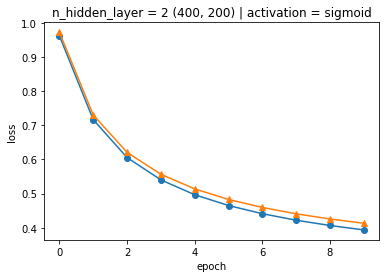

In [51]:
y_pred = dnn.predict(X_test)
print("accuracy score:", accuracy_score(y_test, y_pred))

plt.plot(dnn.train_loss, marker="o", label="train_loss")
plt.plot(dnn.val_loss, marker="^", label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("n_hidden_layer = 2 (400, 200) | activation = sigmoid")
plt.show()

In [52]:
dnn_5 = ScratchDeepNeuralNetrowkClassifier([500, 300, 150, 100, 50], lr=1e-3, activation="sigmoid", optimizer="adagrad")
dnn_5.fit(X_train, y_train, X_val, y_val, epoch=10, batch_size=20)

Train loss of epoch 0: 1.83953821686157
Train loss of epoch 1: 1.6059132143018742
Train loss of epoch 2: 1.4593601687848707
Train loss of epoch 3: 1.3430232059498266
Train loss of epoch 4: 1.247413221793027
Train loss of epoch 5: 1.1685098945365624
Train loss of epoch 6: 1.10272537290258
Train loss of epoch 7: 1.0470489202344682
Train loss of epoch 8: 0.9991305684596347
Train loss of epoch 9: 0.9572539139593458


accuracy score: 0.8125


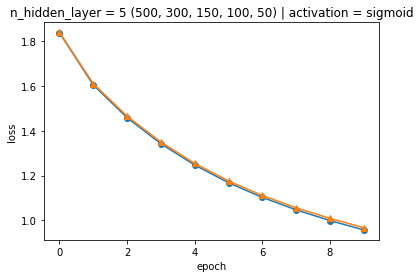

In [53]:
print("accuracy score:", accuracy_score(y_test, dnn_5.predict(X_test)))

plt.plot(dnn_5.train_loss, marker="o", label="train_loss")
plt.plot(dnn_5.val_loss, marker="^", label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("n_hidden_layer = 5 (500, 300, 150, 100, 50) | activation = sigmoid")
plt.show()

In [54]:
dnn_ReLU = ScratchDeepNeuralNetrowkClassifier([400, 200], lr=1e-3, activation="ReLU", optimizer="adagrad")
dnn_ReLU.fit(X_train, y_train, X_val, y_val, epoch=10, batch_size=20)

Train loss of epoch 0: 0.27121485295365744
Train loss of epoch 1: 0.23193642882199186
Train loss of epoch 2: 0.21078808139272578
Train loss of epoch 3: 0.19627639076267347
Train loss of epoch 4: 0.18528362507828766
Train loss of epoch 5: 0.17642444699246224
Train loss of epoch 6: 0.16899820801588092
Train loss of epoch 7: 0.162609378824
Train loss of epoch 8: 0.15703365550316745
Train loss of epoch 9: 0.1520953441263462


accuracy score: 0.9535


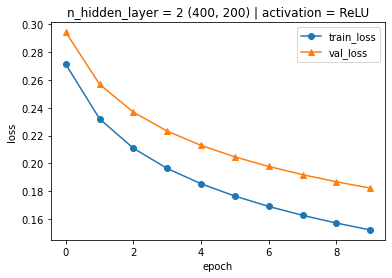

In [55]:
print("accuracy score:", accuracy_score(y_test, dnn_ReLU.predict(X_test)))

plt.plot(dnn_ReLU.train_loss, marker="o", label="train_loss")
plt.plot(dnn_ReLU.val_loss, marker="^", label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("n_hidden_layer = 2 (400, 200) | activation = ReLU")
plt.legend()
plt.show()

In [56]:
dnn_large = ScratchDeepNeuralNetrowkClassifier([600, 300], lr=1e-3, activation="ReLU", optimizer="adagrad")
dnn_large.fit(X_train, y_train, X_val, y_val, epoch=10, batch_size=20)

Train loss of epoch 0: 0.2326816468272717
Train loss of epoch 1: 0.1965340703698487
Train loss of epoch 2: 0.17678101310431885
Train loss of epoch 3: 0.16317135470167063
Train loss of epoch 4: 0.15284380177904083
Train loss of epoch 5: 0.144582307670061
Train loss of epoch 6: 0.13774358296568767
Train loss of epoch 7: 0.13191038934889684
Train loss of epoch 8: 0.12681922930986986
Train loss of epoch 9: 0.12230062154317729


accuracy score: 0.9596


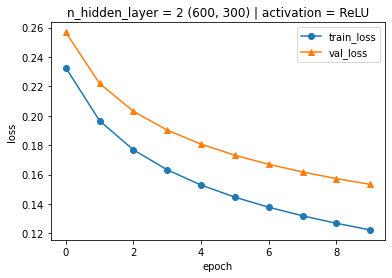

In [57]:
print("accuracy score:", accuracy_score(y_test, dnn_large.predict(X_test)))

plt.plot(dnn_large.train_loss, marker="o", label="train_loss")
plt.plot(dnn_large.val_loss, marker="^", label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("n_hidden_layer = 2 (600, 300) | activation = ReLU")
plt.legend()
plt.show()

In [58]:
dnn_3 = ScratchDeepNeuralNetrowkClassifier([512, 256, 128], lr=1e-3, activation="ReLU", optimizer="adagrad")
dnn_3.fit(X_train, y_train, X_val, y_val, epoch=10, batch_size=20)

Train loss of epoch 0: 0.21892307642447312
Train loss of epoch 1: 0.18352464157239828
Train loss of epoch 2: 0.16455668831150044
Train loss of epoch 3: 0.15136249258599163
Train loss of epoch 4: 0.14132551257865475
Train loss of epoch 5: 0.13327176801638987
Train loss of epoch 6: 0.12656761263240068
Train loss of epoch 7: 0.12080683957677964
Train loss of epoch 8: 0.11582923778125151
Train loss of epoch 9: 0.11139846891504494


accuracy score: 0.9617


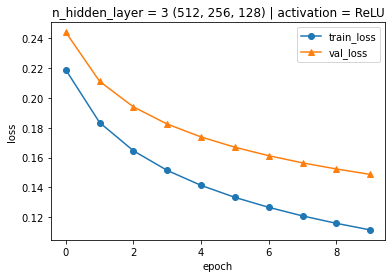

In [59]:
print("accuracy score:", accuracy_score(y_test, dnn_3.predict(X_test)))

plt.plot(dnn_3.train_loss, marker="o", label="train_loss")
plt.plot(dnn_3.val_loss, marker="^", label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("n_hidden_layer = 3 (512, 256, 128) | activation = ReLU")
plt.legend()
plt.show()

Summary
1. When the number of neurons is increased
2. When increasing the number of hidden layers
3. When the activation function is changed from Sigmoid ⇒ ReLU

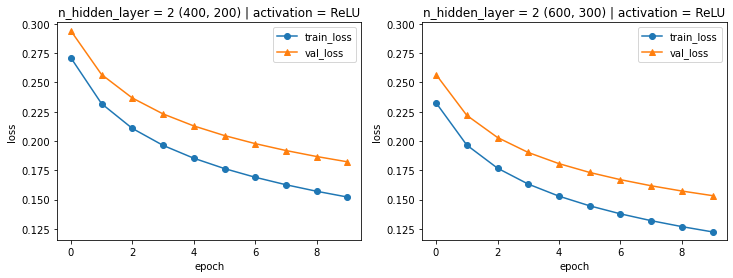

In [60]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

axes[0].plot(dnn_ReLU.train_loss, marker="o", label="train_loss")
axes[0].plot(dnn_ReLU.val_loss, marker="^", label="val_loss")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].set_title("n_hidden_layer = 2 (400, 200) | activation = ReLU")
axes[0].legend()


axes[1].plot(dnn_large.train_loss, marker="o", label="train_loss")
axes[1].plot(dnn_large.val_loss, marker="^", label="val_loss")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("loss")
axes[1].set_title("n_hidden_layer = 2 (600, 300) | activation = ReLU")
axes[1].legend()

y_min0, y_max0 = axes[0].get_ylim()
y_min1, y_max1 = axes[1].get_ylim()

y_min = min(y_min0, y_min1)
y_max = max(y_max0, y_max1)

axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

plt.show()


Increasing the number of neurons can accommodate more complex problems

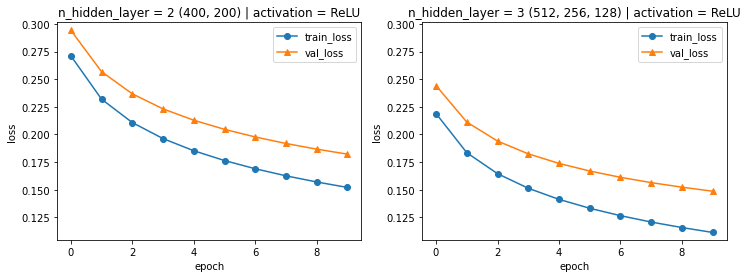

In [61]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

axes[0].plot(dnn_ReLU.train_loss, marker="o", label="train_loss")
axes[0].plot(dnn_ReLU.val_loss, marker="^", label="val_loss")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].set_title("n_hidden_layer = 2 (400, 200) | activation = ReLU")
axes[0].legend()


axes[1].plot(dnn_3.train_loss, marker="o", label="train_loss")
axes[1].plot(dnn_3.val_loss, marker="^", label="val_loss")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("loss")
axes[1].set_title("n_hidden_layer = 3 (512, 256, 128) | activation = ReLU")
axes[1].legend()

y_min0, y_max0 = axes[0].get_ylim()
y_min1, y_max1 = axes[1].get_ylim()

y_min = min(y_min0, y_min1)
y_max = max(y_max0, y_max1)

axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

plt.show()

More accuracy with more layers

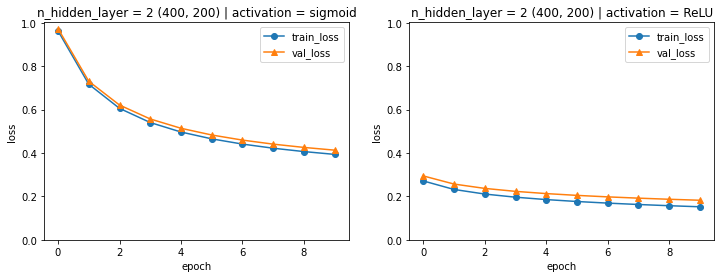

In [62]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

axes[0].plot(dnn.train_loss, marker="o", label="train_loss")
axes[0].plot(dnn.val_loss, marker="^", label="val_loss")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].set_title("n_hidden_layer = 2 (400, 200) | activation = sigmoid")
y_min, y_max = axes[0].get_ylim()
axes[0].set_ylim(0, y_max)
axes[0].legend()

axes[1].plot(dnn_ReLU.train_loss, marker="o", label="train_loss")
axes[1].plot(dnn_ReLU.val_loss, marker="^", label="val_loss")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("loss")
axes[1].set_title("n_hidden_layer = 2 (400, 200) | activation = ReLU")
axes[1].set_ylim(0, y_max)
axes[1].legend()
plt.show()

There is a big difference in accuracy by changing the type of activation function

# Test

In [63]:
class TestInitializer1:
    def W(self, n_nodes1, n_nodes2):
        W = np.array([[5, 3, 1], [4, 2, 0]], dtype=np.float)
        return W
    
    def B(self, n_nodes2):
        B = np.array([-20, -10, -12], dtype=np.float)
        return B

    
class TestInitializer2:
    def W(self, n_nodes1, n_nodes2):
        W = np.array([[-4, 3], [-6, 1], [-8, 5]], dtype=np.float)
        return W
    
    def B(self, n_nodes2):
        B = np.array([10, 15], dtype=np.float)
        return B

class TestInitializer3:
    def W(self, n_nodes1, n_nodes2):
        W = np.array([[-4, 3, -3, 5], [-6, 1, -2, 2]], dtype=np.float)
        return W
    
    def B(self, n_nodes2):
        B = np.array([10, 15, -10, -5], dtype=np.float)
        return B


In [64]:
XX = np.array([[1,2],[3,4],[5,6],[7,8]], dtype=np.float)
yy = np.array([0,1,2,3])

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
yy_one_hot = enc.fit_transform(yy[:, np.newaxis])

n_nodes1 = 3
n_nodes2 = 2
n_output = yy_one_hot.shape[1]
n_features = XX.shape[1]
lr = 0.01
sigma = 0.1

optimizer = SGD(lr)
FC1 = FC(n_features, n_nodes1, TestInitializer1(), optimizer)
activation1 = Sigmoid()
FC2 = FC(n_nodes1, n_nodes2, TestInitializer2(), optimizer)
activation2 = Sigmoid()
FC3 = FC(n_nodes2, n_output, TestInitializer3(), optimizer)
activation3 = Softmax()

A1 = FC1.forward(XX)
Z1 = activation1.forward(A1)
A2 = FC2.forward(Z1)
Z2 = activation2.forward(A2)
A3 = FC3.forward(Z2)
Z3 = activation3.forward(A3)

dA3 = activation3.backward(Z3, yy_one_hot) 
dZ2 = FC3.backward(dA3)
dA2 = activation2.backward(dZ2)
dZ1 = FC2.backward(dA2)
dA1 = activation1.backward(dZ1)
dZ0 = FC1.backward(dA1)## Do not use  dZ0